# A study on spontaneous decay rate of an atom in presence of a square dielectric waveguide using BEM approach

In these notes, I calculate the Local Density of States (LDOS), or the imaginary part of the on-site Green's function and hence the modified spontaneous emission rate of an atom in presence of a square dielectric waveguide using the Boundary Element Method (BEM). The BEM code is from Prof. Alejandro Manjavacas's group. 

This is an [IJulia notebook](https://github.com/JuliaLang/IJulia.jl), which provides a nice
browser-based [Jupyter](http://jupyter.org/) interface to the [Julia language](http://julialang.org/), a high-level dynamic language (similar to Matlab or Python+SciPy) for technical computing.  The notebook allows us to combine code and results in one place.

We are only manipulating the generated data from the simulation results in this notebook. As a brief recap of the simulation process, I have used a compiled BEM code by Alejandro's group written in C++ called `bem2D` on a cluster computing system. A configuration C++ code is defined in the file `scripts_ldos.cpp` which is in the same folder as `bem2D`. I compiled the script and put the generated executable into another folder called `p3`, for example, by
```
g++ scripts_ldos.cpp -lstdc++ -o ../p3/scripts_ldos
```
Then ran the executable and submitted the generated PBS script to the cluster system to run the simulation:
```
cd ../p3/
./scripts_ldos
qsub ldos_N_1_lam_894_eps_4_0_a_300_b_300_c_5_x_0_y_350_q_0_2_401.pbs
```
Notice that the name of the PBS script is automatically generated based on the configuration parameters for this simulation. The name will vary for different simulations. After running the script, I got a set of data files--one has the same name as the PBS script but with a `.dat` extension for the data table storing the calculated LDOS values; there are another two `*.dat` files for the geometry of boundary and dieletric function distribution. We will look into those data files in the following sections.


## 3D dielectric waveguide simulated in 2D

Just a little more detail on the simulation itself: By assuming the waveguide along z-axis or the light propagation direction is uniform, one can completely solve the boundary condition problem of dipole emission by simulating the field in one single layer of the xy cross section. The z-component of the field only adds in a phase factor. The data of the simulated result is stored in the /data/ folder of this repo. 

We can read in this data as a matrix of numbers by the `readdlm` function in Julia with the `header=false` option meaning that it reads the first line as the beginning of the data entries without a list of strings describing each column.

Now, let's plot the results.  I'll use the [PyPlot](https://github.com/stevengj/PyPlot.jl) package in Julia, which is an interface to the sophisticated [matplotlib](http://matplotlib.org/) Python plotting library.   We'll plot three things:

* The waveguide structure in terms of $\epsilon$ and the interface boundary between two media.
* Plot the LDOS components for a fixed dipole position.
* Calculate the waveguide-modified spontaneous decay rate when the dipole varies its position outside of the waveguide.



### Plotting the boundary and index of refraction profile of the waveguide in the xy cross section

Our boundary points are meshed in the file `/data/p3/geom_regions_a_300_b_300_c_5.data`, which positions where the equivalent charges and current sources to be computed in the BEM simulation. The waveguide has a square cross-section of a width $a=b=300nm$ ($nm$ is the unit of length) and a index of refraction of $n_1=n_{core}=2$ for the waveguide material and $n_2=n_{clad}=1$ for the vacuum clad. 

It is good to plot out the mesh of index of refraction in space and find out how good is the mesh resolution. This can be done by plotting out the output eps file in a simple data table format, which ends in `.dat`. 

The following will first print out some of the data in order to figure out the physics meaning of the dimensions. They should contain the coordinate and index of refraction information for the simulation.

In [1]:
boundary = readdlm("data/geom_regions_a_300_b_300_c_5.dat", header=false);
boundarypoints = boundary[:,1:2]

10201×2 Array{Float64,2}:
 -180.0  -180.0
 -180.0  -176.4
 -180.0  -172.8
 -180.0  -169.2
 -180.0  -165.6
 -180.0  -162.0
 -180.0  -158.4
 -180.0  -154.8
 -180.0  -151.2
 -180.0  -147.6
 -180.0  -144.0
 -180.0  -140.4
 -180.0  -136.8
    ⋮          
  180.0   140.4
  180.0   144.0
  180.0   147.6
  180.0   151.2
  180.0   154.8
  180.0   158.4
  180.0   162.0
  180.0   165.6
  180.0   169.2
  180.0   172.8
  180.0   176.4
  180.0   180.0

In [2]:
epsilon3D = readdlm("data/geom_a_300_b_300_c_5.dat", header=false);
epsilon2Dpoints = epsilon3D[:,[1,2,4]]

620×3 Array{Float64,2}:
    0.966667   150.0    2.0
    2.9        150.0    2.0
    4.83333    150.0    2.0
    6.76667    150.0    2.0
    8.7        150.0    2.0
   10.6333     150.0    2.0
   12.5667     150.0    2.0
   14.5        150.0    2.0
   16.4333     150.0    2.0
   18.3667     150.0    2.0
   20.3        150.0    2.0
   22.2333     150.0    2.0
   24.1667     150.0    2.0
    ⋮                      
 -150.0        142.1    2.0
 -150.0        144.033  2.0
 -149.938     -145.782  1.0
 -149.455     -147.27   1.0
 -148.536     -148.536  1.0
 -147.27      -149.455  1.0
 -145.782     -149.938  1.0
 -145.782      149.938  1.0
 -147.27       149.455  1.0
 -148.536      148.536  1.0
 -149.455      147.27   1.0
 -149.938      145.782  1.0

Now we plot out the data in a 2D (xy) plane. 

180.0

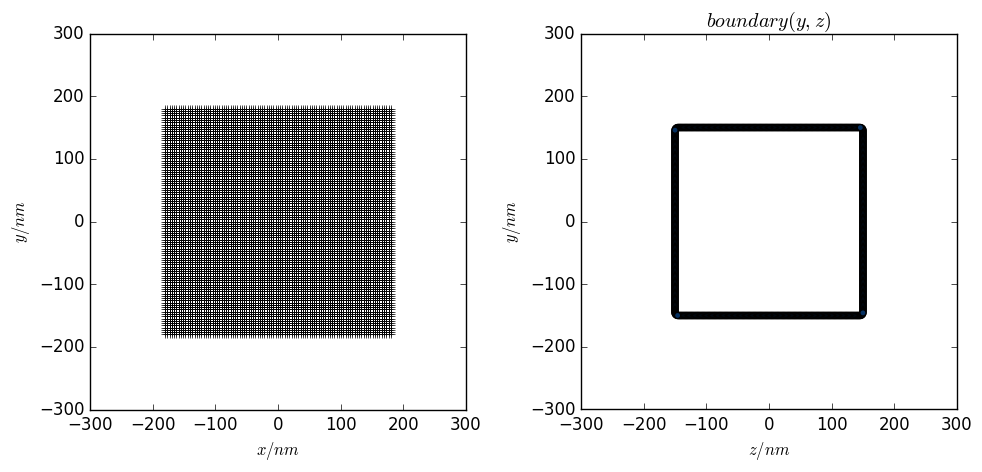

PyObject <matplotlib.text.Text object at 0x7f23f5bba510>

In [3]:
using PyPlot
#println(convert(Int64,floor(lenz/2)))
x = boundarypoints[:,1]
y = boundarypoints[:,2]
lenx = length(x)

fig = figure("Boundary points plot",figsize=(10,10))
ax = fig[:add_subplot](1,2,1)
cp = ax[:plot](x, y, "k+", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"x/nm")
ylabel(L"y/nm")
axis("image")
xlim(-300,300)
ylim(-300,300)
tight_layout()
gcf() # Needed for IJulia to plot inline
display(maximum(abs(x)))

subplot(1,2,2)
x_eps = epsilon2Dpoints[:,1]; y_eps = epsilon2Dpoints[:,2]; v_eps = epsilon2Dpoints[:,3];
#triangulationcoord = triangulation(x_eps,y_eps);
ax = fig[:add_subplot](1,2,2)
#cp = ax[:tripcolor](triangulationcoord,v_eps)
c = get_cmap("RdBu")
rgbs = [c(norm(value)) for value in v_eps]
scatter(x_eps,y_eps,c=rgbs)
#ax[:clabel](cp, inline=1, fontsize=1)
#ax = fig[:add_subplot](1,2,2,projection="3d")
#cp = ax[:plot_surface](zygrid, yzgrid, squeeze(sqrt(ɛ[63,:,:]),1),rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.8, linewidth=0.2)

xlabel(L"z/ nm")
ylabel(L"y/ nm")
axis("image")
xlim(-300,300)
ylim(-300,300)
tight_layout()
#gcf() # Needed for IJulia to plot inline
title(L"boundary(y,z)")

***I don't quite understand the first plot***, in which I expect the shadowed area is the computing region. But the region is a $180nm\times 180nm$ square which is neither the region of waveguide nor to cover the dipole source position. The figure on the right seems covers the boundary points pretty well, although the plot didn't resolve the image on the corners clearly.


# Plotting the LDOS components with a fixed dipole position

To calculate the modified decay rates, we need to use the LDOS value at the dipole position. The result is calculated at a series of $k$ points. I expect to see a continuous positive curve when $k\in [0,1]\omega/c$ or in the radiative mode regime and a single positive spark in the $[1,2]\omega/c$ or guided mode regime--given the waveguide is a single-mode waveguide.

8.79907

8.79907

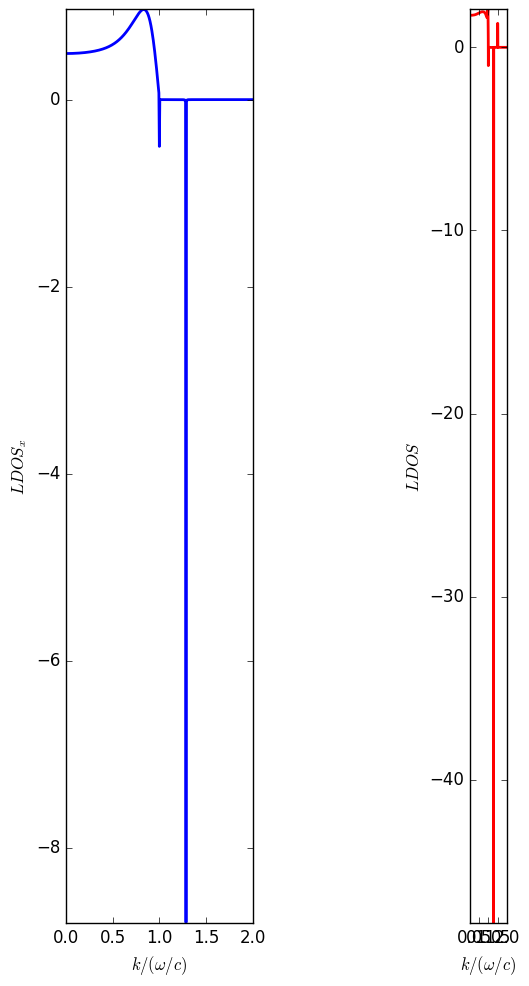

In [4]:
ldos = readdlm("data/ldos_N_1_lam_894_eps_4_0_a_300_b_300_c_5_x_0_y_350_q_0_2_401.dat", header=false);
#ldos = readdlm("data/ldos_N_1_lam_894_eps_4_0.001_a_300_b_300_c_5_x_0_y_350_q_0.1_4_101.dat", header=false);
ldosqpoints = ldos[:,[2,5,6,7,8]]
using PyPlot
#println(convert(Int64,floor(lenz/2)))
q = ldosqpoints[:,1]
ldosx = ldosqpoints[:,2]
ldosy = ldosqpoints[:,3]
ldosz = ldosqpoints[:,4]
ldos_av = ldosqpoints[:,5]
lenx = length(q)

fig = figure("LDOS q plot",figsize=(10,10))
ax = fig[:add_subplot](1,2,1)
cp = ax[:plot](q, ldosx, "b-", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"k/(\omega/c)")
ylabel(L"LDOS_x")
axis("image")
xlim(-0.0,2)
#ylim(-300,300)
tight_layout()
gcf() # Needed for IJulia to plot inline
display(maximum(abs(ldosx)))

ax = fig[:add_subplot](1,2,2)
cp = ax[:plot](q, ldos_av, "r-", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"k/(\omega/c)")
ylabel(L"LDOS")
axis("image")
xlim(-0.0,2)
#ylim(-300,300)
tight_layout()
gcf() # Needed for IJulia to plot inline
display(maximum(abs(ldosx)))

As you can see, ***there is a negative spark in the guided mode regime***. It could be a numerical error in the code and may be removed using some tricks.

Now we can integrate the $\mathrm{LDOS}_i$ values over $k$ along the whole axis to obtain the total decay rate or from $0$ to $\omega/c$ to obtain the radiative mode contribution for the decay rate. Each integral can be performed as a sum over all discrete points along the $k$-axis using the Trapezoid approximation as below:
$$\begin{align}\int \mathrm{LDOS}_i(k)dk &= \sum_{j=1,\cdots,N-1} \frac{\mathrm{LDOS}_i(k_j)+\mathrm{LDOS}_i(k_j+1)}{2}\Delta k\\
&= \left(\frac{\mathrm{LDOS}_i(k_N)+\mathrm{LDOS}_i(k_N)}{2}+\sum_{j=2,\cdots,N-1}\mathrm{LDOS}_i(k_j)\right)\Delta k,\end{align}$$
where $N$ is the total number of data points along the $k$-axis, and $\Delta k=k_j-k_{j-1}=k_2-k_1$ as the interval of $k$-vector in a uniform distribution manner.

In our case, the integrand is discontinuous and breaks the continuity at $k=k_0=\omega/c$ point. Therefore, we divide our integration limit into the $[0,n_2)k_0$ and $(n_2,n_1]k_0$ two regions corresponding to radiation mode contribution and guided mode contribution parts, where $n_2=1$ is the index of refraction of the vacuum clad and $n_1=2$ is the index of refraction of the waveguide bulk material. Since there are surdden jumps in the guided mode regime, the integration may have some error using current method, but it shouldn't be too large as the jumps are in small intervals.

In [5]:
length_of_q=length(ldosqpoints[:,1])
breakpoint = Int(floor((length_of_q-1)/2)) # The breaking point of index is chosen under the fact that the radiation contribution part takes a half space for $n_1=2$.
using NumericalMath
ldos_x_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,2])
ldos_x_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,2])
ldos_x = ldos_x_rad+ldos_x_guide;
ldos_y_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,3])
ldos_y_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,3])
ldos_y = ldos_y_rad+ldos_y_guide;
ldos_z_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,4])
ldos_z_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,4])
ldos_z = ldos_z_rad+ldos_z_guide;
ldos_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,5])
ldos_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,5])
ldos_total = ldos_rad + ldos_guide;
# Print out the result.
@printf("\Delta k = %4f k_0.\n",ldosqpoints[2,1]-ldosqpoints[1,1])
@printf("LDOS_x_rad=%5f, LDOS_x_guide=%5f, LDOS_x=%5f;\n",ldos_x_rad,ldos_x_guide,ldos_x)
@printf("LDOS_y_rad=%5f, LDOS_y_guide=%5f, LDOS_y=%5f;\n",ldos_y_rad,ldos_y_guide,ldos_y)
@printf("LDOS_z_rad=%5f, LDOS_z_guide=%5f, LDOS_z=%5f;\n",ldos_z_rad,ldos_z_guide,ldos_z)
@printf("LDOS_rad = %5f, LDOS_guide = %5f, LDOS = %5f.",ldos_rad,ldos_guide,ldos_total)

Delta k = 0.005000 k_0.
LDOS_x_rad=0.624520, LDOS_x_guide=-0.046715, LDOS_x=0.577805;
LDOS_y_rad=0.661676, LDOS_y_guide=-0.137483, LDOS_y=0.524193;
LDOS_z_rad=0.525642, LDOS_z_guide=-0.054018, LDOS_z=0.471624;
LDOS_rad = 1.811839, LDOS_guide = -0.238216, LDOS = 1.573623.

Notice that the result above was calculated using a $k$-resolution of $\Delta k= 0.005k_0$. We can compare the results above with a coarser gridding case with $\Delta k= 0.01k_0$. The LDOS values can be then calculated as below.

In [6]:
ldos = readdlm("data/ldos_N_1_lam_894_eps_4_0_a_300_b_300_c_5_x_0_y_350_q_0_2_201.dat", header=false);
ldosqpoints = ldos[:,[2,5,6,7,8]]
length_of_q=length(ldosqpoints[:,1])
breakpoint = Int(floor((length_of_q-1)/2)) # The breaking point of index is chosen under the fact that the radiation contribution part takes a half space for $n_1=2$.
using NumericalMath
ldos_x_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,2])
ldos_x_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,2])
ldos_x = ldos_x_rad+ldos_x_guide;
ldos_y_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,3])
ldos_y_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,3])
ldos_y = ldos_y_rad+ldos_y_guide;
ldos_z_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,4])
ldos_z_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,4])
ldos_z = ldos_z_rad+ldos_z_guide;
ldos_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,5])
ldos_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,5])
ldos_total = ldos_rad + ldos_guide;
# Print out the result.
display("\Delta k = $(ldosqpoints[2,1]-ldosqpoints[1,1]) k_0.")
@printf("LDOS_x_rad=%5f, LDOS_x_guide=%5f, LDOS_x=%5f;\n",ldos_x_rad,ldos_x_guide,ldos_x)
@printf("LDOS_y_rad=%5f, LDOS_y_guide=%5f, LDOS_y=%5f;\n",ldos_y_rad,ldos_y_guide,ldos_y)
@printf("LDOS_z_rad=%5f, LDOS_z_guide=%5f, LDOS_z=%5f;\n",ldos_z_rad,ldos_z_guide,ldos_z)
@printf("LDOS_rad = %5f, LDOS_guide = %5f, LDOS = %5f.",ldos_rad,ldos_guide,ldos_total)
#ldosqpoints[breakpoint,2]

"Delta k = 0.01 k_0."

LDOS_x_rad=0.623963, LDOS_x_guide=-0.004968, LDOS_x=0.618995;
LDOS_y_rad=0.657902, LDOS_y_guide=-0.002447, LDOS_y=0.655455;
LDOS_z_rad=0.525345, LDOS_z_guide=0.012674, LDOS_z=0.538019;
LDOS_rad = 1.807210, LDOS_guide = 0.005258, LDOS = 1.812468.

We can see that there are considerable differences between the integrated LDOS values for the two cases. The main differences are from the guided mode contribution part to LDOS, and should be related to the negative sparks. Therefore, I suspect that I still need to find a way to rule out the spark errors in order to calculate the LDOS values accurate. The resolution of the later case seems fine for the radiation contribution part, at least.

I didn't plot the details of the LDOS components for this case, but there are also negative sparks in the guided mode regime. The sparks disappear in the case of $\Delta k=0.05k_0$, but the integrals may not be accurate enough.

## LDOS components as a function of dipole position

We have some simulation data when the dipole is placed at different locations along the y-axis and hence we should be able to plot out the LDOS(y) function. But before doing this, we need to fix the numerical error problem.

Decide resolution and other details...

Results...